In [1]:
import tensorflow as tf

C:\Users\Charles\Anaconda3\envs\condathree\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, GRU, LSTM
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.layers.merge import Concatenate

Using TensorFlow backend.


In [3]:
import numpy as np

In [4]:
manager_internal_shape = 100
pitch_internal_shape = 100
rhythm_internal_shape = 100

pitch_output_shape = 33
rhythm_output_shape = 16

manager_gru = GRU(manager_internal_shape, return_state = False)
pitch_gru = GRU(pitch_internal_shape, return_state = False)
rhythm_gru = GRU(rhythm_internal_shape, return_state = False)

densor_pitch = Dense(pitch_output_shape, activation='softmax')
densor_rhythm = Dense(rhythm_output_shape, activation='softmax')

In [5]:
def build_model(manager_gru, pitch_gru, rhythm_gru, densor_pitch, densor_rhythm):

    non_trainable_first = 8

    pitch_output_shape = 33
    rhythm_output_shape = 16

    manager_internal_shape = 100
    pitch_internal_shape = 100
    rhythm_internal_shape = 100

    n_values = 70
    Tx = 50
    
    X_pitch = Input(shape = (Tx, pitch_output_shape), name = 'X_pitch')
    X_rhythm = Input(shape = (Tx, rhythm_output_shape), name = 'X_rhythm')

    reshapor_pitch = Reshape((pitch_output_shape, 1))
    reshapor_rhythm = Reshape((rhythm_output_shape, 1))
    reshapor_manager = Reshape((manager_internal_shape, 1))
    reshapor_concat = Reshape((pitch_internal_shape + rhythm_internal_shape, 1))


    #densor_pitch = Dense(pitch_output_shape, activation='softmax')
    #densor_rhythm = Dense(rhythm_output_shape, activation='softmax')

    manager_state_0 = Input(shape=(manager_internal_shape, ), name = 'manager_state_0')
    pitch_state_0 = Input(shape = (pitch_internal_shape, ), name = 'pitch_state_0')
    rhythm_state_0 = Input(shape = (rhythm_internal_shape, ), name = 'rhythm_state_0')

    manager_state = manager_state_0
    pitch_state = pitch_state_0
    rhythm_state = rhythm_state_0

    #manager_gru = GRU(manager_internal_shape, return_state = False)
    #pitch_gru = GRU(pitch_internal_shape, return_state = False)
    #rhythm_gru = GRU(rhythm_internal_shape, return_state = False)

    out_pitches = []
    out_rhythms = []

    for t in range(Tx):
        print(t)

        get_pitch_t =  Lambda(lambda x: reshapor_pitch(x[:,  t, :])) 
        get_rhythm_t = Lambda(lambda x: reshapor_rhythm(x[:, t, :]))

        pitch = Concatenate(axis = 1)([get_pitch_t(X_pitch), reshapor_manager(manager_state)])
        rhythm = Concatenate(axis = 1)([get_rhythm_t(X_rhythm), reshapor_manager(manager_state)])
        
        #print(get_pitch_t(X_pitch).shape)
        
        pitch_state = pitch_gru(pitch, initial_state = [pitch_state])
        rhythm_state = rhythm_gru(rhythm, initial_state = [rhythm_state])

        #print(pitch_state)

        concat = reshapor_concat(Concatenate(axis = 1)([pitch_state, rhythm_state]))
        manager_state = manager_gru(concat, initial_state = [manager_state])

        if (t >= non_trainable_first):

            out_pitches.append(densor_pitch(pitch_state))
            out_rhythms.append(densor_rhythm(rhythm_state))

        out = out_pitches + out_rhythms

    model_general = Model(inputs = [X_pitch, X_rhythm, pitch_state_0, rhythm_state_0, manager_state_0], outputs = out)

    return model_general


In [6]:
model = build_model(manager_gru, pitch_gru, rhythm_gru, densor_pitch, densor_rhythm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [7]:
from keras.losses import categorical_crossentropy#(y_true, y_pred)
from keras import backend as K
def custom_objective(y_true, y_pred):
    #print(y_true.shape)
    #print(y_pred.shape)
    length_out = y_pred.shape[1] // 2
    return K.mean(categorical_crossentropy(y_true[:,:length_out], y_pred[:,:length_out]) + categorical_crossentropy(y_true[:,length_out:], y_pred[:,length_out:]))

In [8]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss=custom_objective, metrics=['accuracy'])

In [9]:
import pickle
from keras.utils import np_utils

In [10]:
rythm_X = pickle.load(open( "jazz_rythm.txt", "rb" ), encoding = 'bytes')

In [11]:
pitch_X = pickle.load(open( "jazz_pitch.txt", "rb" ), encoding = 'bytes')

In [12]:
non_trainable_first = 8
Tx = 50

pitch_output_shape = 33
rythm_output_shape = 16

X_pitch = []
X_rythm = []

y_pitch = []
y_rythm = []



for pitch_s, rythm_s in zip(pitch_X, rythm_X):
    lgth = (len(pitch_s) - 1) // Tx
    for i in range(lgth):
        
        
        X_pitch.append(np_utils.to_categorical(pitch_s[i * Tx: (i + 1) * Tx],pitch_output_shape ))
        y_pitch.append(np_utils.to_categorical(pitch_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1],pitch_output_shape))
        
        X_rythm.append(np_utils.to_categorical(rythm_s[i * Tx: (i + 1) * Tx],rythm_output_shape))
        y_rythm.append(np_utils.to_categorical(rythm_s[i * Tx + non_trainable_first + 1: (i + 1) * Tx + 1],rythm_output_shape))
        

#Y = [[y_pitch[i], y_rythm[i]] for i in range(len(y_pitch))]        

In [28]:
Y = [list(y_pitch[i])+list(y_rythm[i]) for i in range(len(y_pitch))]#
Y = [np.array([y[i] for y in Y[:1500]]) for i in range(84)]

In [14]:
#Y = [[y_pitch[i], y_rythm[i]] for i in range(len(y_pitch))] 
np.array([len(y) for y in y_pitch])[np.array([len(y) for y in y_pitch]) != 42]

array([], dtype=int32)

In [101]:
Y[0][0].shape

(170,)

In [29]:
X_pitch_np = np.array(X_pitch)[:1500]#[x for x in X_pitch]
X_rythm_np = np.array(X_rythm)[:1500]

In [156]:
np.min(X_pitch_np[0],axis = 1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [32]:
len(X_pitch)

20776

In [30]:
m = X_pitch_np.shape[0]

manager_internal_shape = 100
pitch_internal_shape = 100
rhythm_internal_shape = 100

pitch_state_0 = np.zeros((m, pitch_internal_shape))
rhythm_state_0 = np.zeros((m, rhythm_internal_shape))
manager_state_0 = np.zeros((m, manager_internal_shape))

model.fit([X_pitch_np, X_rythm_np,  pitch_state_0, rhythm_state_0, manager_state_0], Y, batch_size = 100, epochs=1, verbose = 1)

Epoch 1/1
1500/1500 [==============================] - 441s 294ms/step - loss: 142.2731 - dense_1_loss: 2.4445 - dense_2_loss: 0.9451 - dense_1_acc: 0.1233 - dense_1_acc_1: 0.1307 - dense_1_acc_2: 0.1267 - dense_1_acc_3: 0.1247 - dense_1_acc_4: 0.1240 - dense_1_acc_5: 0.1367 - dense_1_acc_6: 0.1233 - dense_1_acc_7: 0.1193 - dense_1_acc_8: 0.1220 - dense_1_acc_9: 0.1240 - dense_1_acc_10: 0.1213 - dense_1_acc_11: 0.1267 - dense_1_acc_12: 0.1207 - dense_1_acc_13: 0.1320 - dense_1_acc_14: 0.1153 - dense_1_acc_15: 0.1193 - dense_1_acc_16: 0.1247 - dense_1_acc_17: 0.1267 - dense_1_acc_18: 0.1080 - dense_1_acc_19: 0.1333 - dense_1_acc_20: 0.1193 - dense_1_acc_21: 0.1207 - dense_1_acc_22: 0.1200 - dense_1_acc_23: 0.1280 - dense_1_acc_24: 0.1247 - dense_1_acc_25: 0.1247 - dense_1_acc_26: 0.1227 - dense_1_acc_27: 0.1113 - dense_1_acc_28: 0.1167 - dense_1_acc_29: 0.1380 - dense_1_acc_30: 0.1280 - dense_1_acc_31: 0.1267 - dense_1_acc_32: 0.1213 - dense_1_acc_33: 0.1273 - dense_1_acc_34: 0.1207 - d

In [ ]:
model.summ

In [ ]:
X_pitch, X_rhythm, pitch_state_0, rhythm_state_0, manager_state_0

In [ ]:
model.summary()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
def make_prediction(manager_gru, pitch_gru, rhythm_gru, densor_pitch, densor_rhythm):

    non_trainable_first = 8

    pitch_output_shape = 33
    rhythm_output_shape = 16

    manager_internal_shape = 100
    pitch_internal_shape = 100
    rhythm_internal_shape = 100

    Tx = 50
    
    X_pitch = Input(shape = (non_trainable_first, pitch_output_shape), name = 'X_pitch')
    X_rhythm = Input(shape = (non_trainable_first, rhythm_output_shape), name = 'X_rhythm')

    reshapor_pitch = Reshape((pitch_output_shape, 1))
    reshapor_rhythm = Reshape((rhythm_output_shape, 1))
    reshapor_manager = Reshape((manager_internal_shape, 1))
    
    reshapor_concat = Reshape((pitch_internal_shape + rhythm_internal_shape, 1))


    #densor_pitch = Dense(pitch_output_shape, activation='softmax')
    #densor_rhythm = Dense(rhythm_output_shape, activation='softmax')

    manager_state_0 = Input(shape=(manager_internal_shape, ), name = 'manager_state_0')
    pitch_state_0 = Input(shape = (pitch_internal_shape, ), name = 'pitch_state_0')
    rhythm_state_0 = Input(shape = (rhythm_internal_shape, ), name = 'rhythm_state_0')

    manager_state = manager_state_0
    pitch_state = pitch_state_0
    rhythm_state = rhythm_state_0

    #manager_gru = GRU(manager_internal_shape, return_state = False)
    #pitch_gru = GRU(pitch_internal_shape, return_state = False)
    #rhythm_gru = GRU(rhythm_internal_shape, return_state = False)



    for t in range(non_trainable_first):
        #print(t)

        get_pitch_t =  Lambda(lambda x: reshapor_pitch(x[:,  t, :])) 
        get_rhythm_t = Lambda(lambda x: reshapor_rhythm(x[:, t, :]))

        pitch = Concatenate(axis = 1)([get_pitch_t(X_pitch), reshapor_manager(manager_state)])
        rhythm = Concatenate(axis = 1)([get_rhythm_t(X_rhythm), reshapor_manager(manager_state)])

        pitch_state = pitch_gru(pitch, initial_state = [pitch_state])
        rhythm_state = rhythm_gru(rhythm, initial_state = [rhythm_state])

        #print(pitch_state)

        concat = reshapor_concat(Concatenate(axis = 1)([pitch_state, rhythm_state]))
        manager_state = manager_gru(concat, initial_state = [manager_state])
        
        output_pitch = densor_pitch(pitch_state)
        output_rhythm = densor_rhythm(rhythm_state)
    
    out_pitches = []
    out_rhythms = []
    
    

    for t in range(100):
        #print(t)
        #Sample pitch
        pitch = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), pitch_output_shape))#np.random.choice(pitch_output_shape, output_pitch)
        
        #pitch = tf.one_hot(sampled_ids_pitch, pitch_output_shape)
        
        #Sample rhythm
        
        #sampled_ids_rhythm = tf.multinomial(output_rhythm, 1)
        
        rhythm = Lambda(lambda x: tf.one_hot(tf.multinomial(x, 1), rhythm_output_shape))
    
        pitch_sampled = reshapor_pitch(pitch(output_pitch))
        rhythm_sampled = reshapor_rhythm(rhythm(output_rhythm))
        
        #print(pitch_sampled)
        out_pitches.append(pitch_sampled)
        out_rhythms.append(rhythm_sampled)
        #####################################
        pitch = Concatenate(axis = 1)([pitch_sampled, reshapor_manager(manager_state)])
        rhythm = Concatenate(axis = 1)([rhythm_sampled, reshapor_manager(manager_state)])

        pitch_state = pitch_gru(pitch, initial_state = [pitch_state])
        rhythm_state = rhythm_gru(rhythm, initial_state = [rhythm_state])
        
        concat = reshapor_concat(Concatenate(axis = 1)([pitch_state, rhythm_state]))
        manager_state = manager_gru(concat, initial_state = [manager_state])
        
        output_pitch = densor_pitch(pitch_state)
        output_rhythm = densor_rhythm(rhythm_state)
        

        

    out = out_pitches + out_rhythms

    model_general = Model(inputs = [X_pitch, X_rhythm, pitch_state_0, rhythm_state_0, manager_state_0], outputs = out)

    return model_general

In [33]:
number_of_notes_to_generate = 100
model_predict = make_prediction(manager_gru, pitch_gru, rhythm_gru, densor_pitch, densor_rhythm)

In [34]:
#m = X_pitch_np.shape[0]

manager_internal_shape = 100
pitch_internal_shape = 100
rhythm_internal_shape = 100

pitch_state_0 = np.zeros((1, pitch_internal_shape))
rhythm_state_0 = np.zeros((1, rhythm_internal_shape))
manager_state_0 = np.zeros((1, manager_internal_shape))

X_pitch_np = np.array(X_pitch)[18,:8].reshape((1,8,33))
X_rythm_np = np.array(X_rythm)[18,:8].reshape((1,8,16))
#X_pitch_np = [np.argmax(x) for x in X_pitch_np]
#X_rythm_np = [np.argmax(x) for x in X_rythm_np]

result = model_predict.predict([X_pitch_np, X_rythm_np,  pitch_state_0, rhythm_state_0, manager_state_0])

[14, 2, 6, 5, 12, 1, 15, 14, 7, 0, 9, 3, 1, 8, 14, 9, 7, 15, 10, 14, 11, 8, 0, 12, 6, 12, 9, 13, 4, 0, 0, 3, 3, 11, 10, 5, 12, 9, 8, 7, 1, 6, 5, 15, 8, 6, 11, 13, 13, 4, 4, 10, 0, 4, 3, 8, 15, 10, 0, 6, 7, 6, 12, 10, 6, 0, 9, 7, 2, 0, 14, 11, 11, 3, 2, 14, 2, 8, 4, 2, 14, 14, 11, 4, 7, 10, 1, 14, 13, 2, 0, 10, 3, 4, 6, 2, 11, 1, 3, 13]
[22, 11, 26, 14, 31, 28, 4, 12, 7, 0, 28, 27, 15, 2, 20, 10, 29, 7, 3, 4, 31, 21, 11, 0, 3, 21, 27, 29, 8, 20, 4, 2, 10, 17, 25, 32, 23, 24, 9, 18, 30, 26, 26, 10, 11, 5, 26, 3, 0, 0, 2, 14, 7, 7, 1, 17, 4, 17, 16, 4, 17, 11, 30, 29, 27, 0, 16, 3, 23, 29, 4, 5, 3, 16, 19, 13, 20, 30, 10, 24, 21, 14, 8, 28, 3, 18, 15, 9, 17, 27, 31, 27, 12, 14, 7, 29, 0, 22, 4, 28]


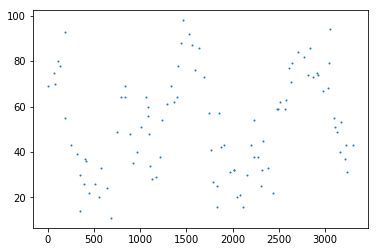

0


In [37]:
seq_p = result[:number_of_notes_to_generate]
seq_r = result[number_of_notes_to_generate:]



X_pitch_np = [np.argmax(x) for x in seq_p]
X_rythm_np = [np.argmax(x) for x in seq_r]

print(X_rythm_np)
print(X_pitch_np)
create_track_new(X_rythm_np,X_pitch_np)

In [36]:
from midiutil import MIDIFile
import matplotlib.pyplot as plt

def create_track_new(seq, seq_pitch):
    
    #num_to_len = {1:1, 2:2, 3:4, 4:8, 5:16, 6:32}
    grain = 32
    one_tact = 128
    tacts_per_min = 75
    tempo    = one_tact * tacts_per_min  # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    track    = 0
    channel  = 0
    time     = 0# to learn
    
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    
    MyMIDI.addNote(track, channel, 120, 0, one_tact / grain, volume)
    tick_count = one_tact / grain
    
    current_pitch = 69
    
    tick_counts = [tick_count]
    pitches = [current_pitch]
    for l,p in zip(seq, seq_pitch):
        current_pitch += (p - 16)
        if current_pitch < 10:
            current_pitch += 50
        if current_pitch > 100:
            current_pitch -= 50
        pitches += [current_pitch]
        #length = num_to_len[l]
        MyMIDI.addNote(track, channel, current_pitch, tick_count, one_tact / grain * (l + 1), volume)
        tick_count = tick_count + one_tact / grain * (l + 1)
        tick_counts += [tick_count]
    
    plt.scatter(tick_counts, pitches, s = 1)
    plt.show()
    print(track)

    with open("zzz.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file) 


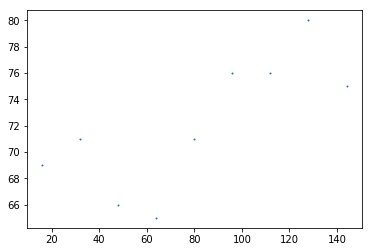

0


In [129]:
X_pitch_np = np.array(X_pitch)[12,:8]
X_rythm_np = np.array(X_rythm)[12,:8]
X_pitch_np = [np.argmax(x) for x in X_pitch_np]
X_rythm_np = [np.argmax(x) for x in X_rythm_np]

create_track_new(X_rythm_np, X_pitch_np)
#print(np.max(np.argmax(X_rythm_np, axis = 1),axis = 1))

In [93]:
np.argmax(X_rythm_np[0])

0

In [49]:
np.argmax(X_pitch_np[1])

84

In [52]:
import mingus.core.intervals as intervals

ModuleNotFoundError: No module named 'keys'

In [35]:
manager_gru(manager_input)

[<tf.Tensor 'gru_7_10/TensorArrayReadV3:0' shape=(?, 200) dtype=float32>,
 <tf.Tensor 'gru_7_10/while/Exit_2:0' shape=(?, 200) dtype=float32>]

In [44]:
out = manager_gru(manager_input)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
manager = Model(inputs = [manager_input], outputs = out[:2])
manager.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
out

[<tf.Tensor 'gru_7_9/TensorArrayReadV3:0' shape=(?, 200) dtype=float32>,
 <tf.Tensor 'gru_7_9/while/Exit_2:0' shape=(?, 200) dtype=float32>]

In [ ]:
manager.predict(np.ones((1,1,100)))

In [29]:
seq = manager_gru(manager_input).compile()

AttributeError: 'list' object has no attribute 'compile'

In [41]:
pitch_gru(pitch_input)

<tf.Tensor 'lstm_5/TensorArrayReadV3:0' shape=(?, 200) dtype=float32>

In [5]:
import numpy as np

In [15]:
sess = tf.Session()

In [39]:
pitch_output_shape = 10

choices_pitch = tf.constant( np.array( [np.arange(pitch_output_shape)]), dtype=tf.int64)

output_pitch = list(np.zeros(pitch_output_shape, dtype = 'int64'))
output_pitch[5] = 0.5
output_pitch[4] = 0.5

output_pitch = tf.constant(output_pitch)
sampled_ids_pitch = tf.multinomial([output_pitch], 12)

ValueError: Shape must be rank 2 but is rank 1 for 'multinomial_431/Multinomial' (op: 'Multinomial') with input shapes: [3], [].

In [ ]:
list(np.zeros(pitch_output_shape, dtype = 'int64'))

In [12]:
with tf.Session() as sess:
    sample = sess.run(sampled_ids_pitch)
    print(sample)
    

[5 5 4 5 5 5 5 5 4 4]


In [50]:
# L has shape [2, 5, 2]
L = tf.constant([[0.9, 0.1]])

dims = L.get_shape().as_list()
N = dims[-1]  # here N = 2

logits = tf.reshape(L, [-1, N])


samples = tf.multinomial(logits, 1)
# We reshape to match the initial shape minus the last dimension
res = tf.reshape(samples, dims[:-1])

In [54]:
with tf.Session() as sess:
    sample = sess.run(res)
    print(sample)

[0]
